<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit

from active_learning_ratio_estimation.dataset import UnparameterizedRatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs_from_simulator, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import UnparameterizedRatioModel, DenseClassifier, FlipoutClassifier

%matplotlib inline

tfd = tfp.distributions

np.random.seed(0)
tf.random.set_seed(0)

In [0]:
def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [0]:
# Build dataset
theta_0 = 0.05
theta_1 = 0.00
n_samples_per_theta = int(1e5)

ds = UnparameterizedRatioDataset(
    n_samples_per_theta=n_samples_per_theta,
    simulator_func=triple_mixture,
    theta_0=theta_0,
    theta_1=theta_1
)

In [0]:
# hyperparams
epochs = 100
patience = 5
validation_split = 0.1
n_hidden = (10, 10)

In [0]:
# regular, uncalibrated model
regular_estimator = DenseClassifier(n_hidden=n_hidden, activation='tanh',
                                    epochs=epochs, patience=patience,
                                    validation_split=validation_split)
regular_uncalibrated = UnparameterizedRatioModel(estimator=regular_estimator, calibration_method=None,
                                                 normalize_input=False)

# bayesian, uncalibrated model
bayesian_estimator = FlipoutClassifier(n_hidden=n_hidden, activation='relu',
                                       epochs=epochs, patience=patience,
                                       validation_split=validation_split)
bayesian_uncalibrated = UnparameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None,
                                                  normalize_input=False)

# regular, calibrated model
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
regular_calibrated = UnparameterizedRatioModel(estimator=clone(regular_estimator), calibration_method='sigmoid',
                                               normalize_input=False, cv=cv)

models = {
    'Regular Uncalibrated': regular_uncalibrated,
    'Bayesian Uncalibrated': bayesian_uncalibrated,
    'Regular Calibrated': regular_calibrated
}

In [0]:
x = np.linspace(-5, 5, int(1e4))


def fit_and_predict(clf):
    clf.fit(ds)
    y_pred = clf.predict_proba(x)[:, 1].squeeze()
    nllr = clf.predict_negative_log_likelihood_ratio(x).squeeze()
    return y_pred, nllr

In [8]:
# Fit and predict models
y_preds = dict()
nllrs = dict()

for model_name, model in models.items():
    print(f'\n******* Fitting {model_name} *******\n')
    y_pred, nllr = fit_and_predict(model)
    y_preds[model_name] = y_pred
    nllrs[model_name] = nllr


******* Fitting Regular Uncalibrated *******

Epoch 1/100
5625/5625 - 14s - loss: 0.6926 - accuracy: 0.5125 - val_loss: 0.6918 - val_accuracy: 0.5163
Epoch 2/100
5625/5625 - 13s - loss: 0.6924 - accuracy: 0.5155 - val_loss: 0.6920 - val_accuracy: 0.5081
Epoch 3/100
5625/5625 - 13s - loss: 0.6923 - accuracy: 0.5155 - val_loss: 0.6920 - val_accuracy: 0.5067
Epoch 4/100
5625/5625 - 13s - loss: 0.6922 - accuracy: 0.5154 - val_loss: 0.6915 - val_accuracy: 0.5166
Epoch 5/100
5625/5625 - 13s - loss: 0.6921 - accuracy: 0.5160 - val_loss: 0.6920 - val_accuracy: 0.5156
Epoch 6/100
5625/5625 - 13s - loss: 0.6921 - accuracy: 0.5166 - val_loss: 0.6915 - val_accuracy: 0.5160
Epoch 7/100
5625/5625 - 13s - loss: 0.6922 - accuracy: 0.5162 - val_loss: 0.6914 - val_accuracy: 0.5152
Epoch 8/100
5625/5625 - 13s - loss: 0.6921 - accuracy: 0.5155 - val_loss: 0.6916 - val_accuracy: 0.5171
Epoch 9/100
5625/5625 - 14s - loss: 0.6922 - accuracy: 0.5173 - val_loss: 0.6921 - val_accuracy: 0.5150
Epoch 10/100
5625

In [0]:
# Add ideal predictions
y_preds['Ideal'] = ideal_classifier_probs_from_simulator(x, triple_mixture, theta_0, theta_1)
nllrs['True'] = negative_log_likelihood_ratio(x, triple_mixture, theta_0, theta_1)
y_preds = pd.DataFrame(y_preds, index=x)
nllrs = pd.DataFrame(nllrs, index=x)

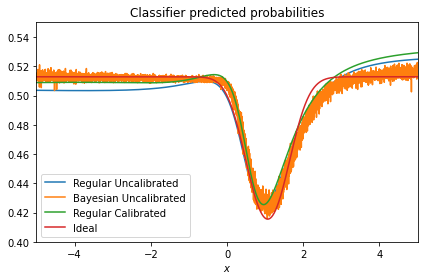

In [10]:
# Plot predictions for classifier decision function
y_preds.plot()
plt.xlim([-5, 5])
plt.ylim([0.4, 0.55])
plt.title('Classifier predicted probabilities')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()

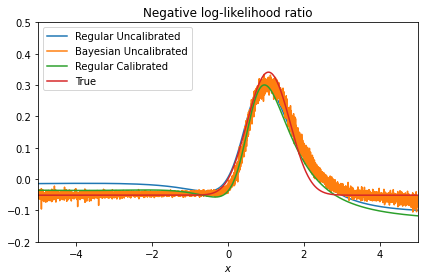

In [11]:
# Plot predictions for negative log likelihood ratio
nllrs.plot()
plt.xlim([-5, 5])
plt.ylim([-0.2, 0.5])
plt.title('Negative log-likelihood ratio')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()

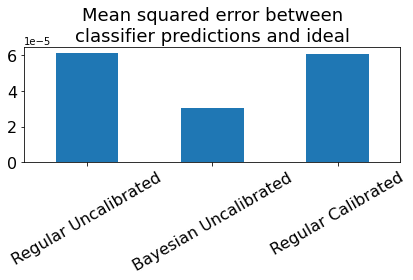

In [12]:
# Calculate MSE between models' predicted probabilities and ideal probabilities 
mses = pd.Series(dtype=float)

for model_name in models:
    mse = np.mean((y_preds[model_name] - y_preds['Ideal']) ** 2)
    mses[model_name] = mse

plt.figure()
mses.plot.bar(fontsize=16, rot=30)
plt.title('Mean squared error between\nclassifier predictions and ideal', fontsize=18)
plt.tight_layout()
plt.show()